# 3. Sampling and Markov Chain Monte Carlo (MCMC)

##### Bibliography:

- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 5
- [Gordon Richard's notebooks](https://github.com/gtrichards/PHYS_T480)
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Additional reading:
- [Jake VanderPlas: "How to be a Bayesian in Python"](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)
- [Thomas Wiecki: "The Inference Button: Bayesian GLMs made easy with PyMC3](https://twiecki.io/blog/2013/08/12/bayesian-glms-1/)

Some imports...

In [1]:
## Hack to fix pymc3 incompatibility with more recent versions of numpy

import numpy

def patch_asscalar(a):
    return a.item()

setattr(numpy, "asscalar", patch_asscalar)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy import stats, integrate
from scipy.stats import norm, cauchy

from astroML.plotting import hist, plot_mcmc
from astroML.plotting.mcmc import convert_to_stdev
from astroML.utils.decorators import pickle_results

import pymc3 as pm
import emcee

import warnings; warnings.simplefilter('ignore')

## Bayes is all about posteriors

* Bayesian inference is all about deriving ***posteriors***. There's no more "certainty", it's all about the probability distributions!

* For dimensions $\gtrsim 3$, brute-force computation of posteriors (i.e., computing all values on a grid) becomes infeasible. We need a smarter method, one that will only compute the values of the posterior where it's appreciably non-zero.

* What do we do???

## The answer is sampling!

* Instead of calculating the value of the posterios for every possible parameter, we sample it!

In [3]:
def twoD_gauss_with_grid():
    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib.patches import Ellipse
    from astroML.stats.random import bivariate_normal

    mean = np.array([0, 0])
    sigma_1 = 2
    sigma_2 = 1
    alpha = np.pi / 4

    #------------------------------------------------------------
    # Draw 10^5 points from a multivariate normal distribution
    #
    np.random.seed(0)
    x, cov = bivariate_normal(mean, sigma_1, sigma_2, alpha, size=100_00,
                              return_cov=True)

    sigma_x = np.sqrt(cov[0, 0])
    sigma_y = np.sqrt(cov[1, 1])
    sigma_xy = cov[0, 1]

    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # plot a 2D histogram/hess diagram of the points
    H, bins = np.histogramdd(x, bins=2 * [np.linspace(-9, 9, 101)])
    ax.imshow(H, origin='lower', cmap=plt.cm.binary, interpolation='nearest',
              extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])

    # draw 1, 2, 3-sigma ellipses over the distribution
    for N in (1, 2, 3):
        ax.add_patch(Ellipse(mean, N * sigma_1, N * sigma_2,
                             angle=alpha * 180. / np.pi, lw=1,
                             ec='k', fc='none'))

    kwargs = dict(ha='left', va='top', transform=ax.transAxes)

    ax.text(0.02, 0.98, r"$\sigma_1 = %i$" % sigma_1, **kwargs)
    ax.text(0.02, 0.93, r"$\sigma_2 = %i$" % sigma_2, **kwargs)
    ax.text(0.02, 0.88, r"$\alpha = \pi / %i$" % (np.pi / alpha), **kwargs)

    ax.text(0.15, 0.98, r"$\sigma_x = %.2f$" % sigma_x, **kwargs)
    ax.text(0.15, 0.93, r"$\sigma_y = %.2f$" % sigma_y, **kwargs)
    ax.text(0.15, 0.88, r"$\sigma_{xy} = %.2f$" % sigma_xy, **kwargs)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base = float(bins[0][1]-bins[0][0]))
    plt.gca().xaxis.set_minor_locator(loc)
    plt.gca().yaxis.set_minor_locator(loc)

    plt.grid(visible=True, which='minor')

    plt.show()
    
    return x

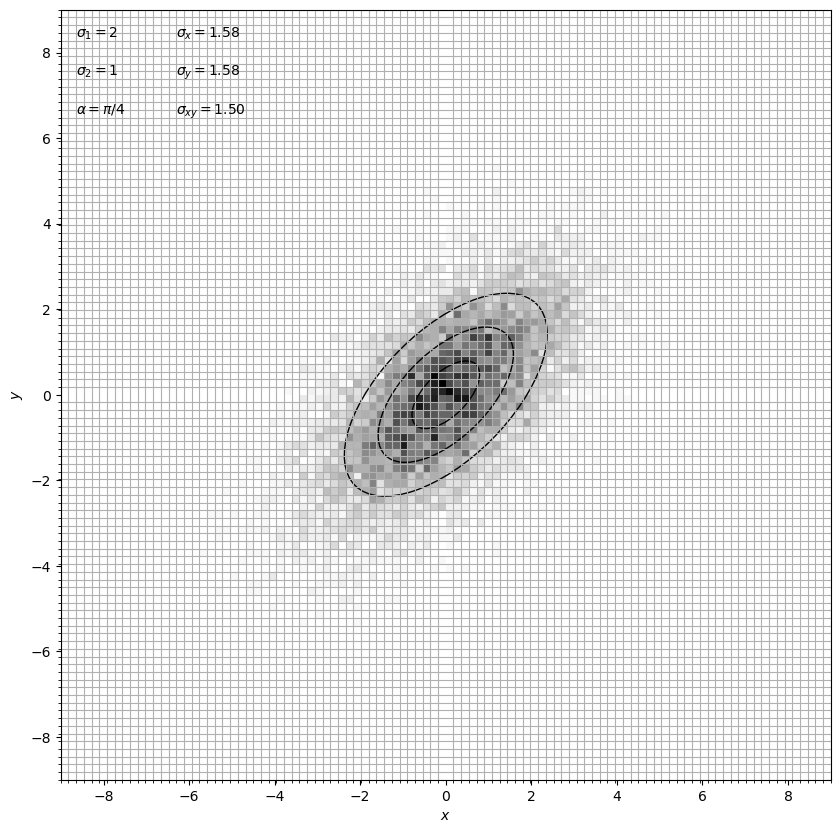

array([[-2.77770063, -2.21179288],
       [-2.96869531,  0.20040625],
       [-1.95008602, -3.33216565],
       ...,
       [ 1.24049979,  1.62468751],
       [ 0.19463384,  0.11365702],
       [ 1.72844543,  1.26666448]])

In [4]:
samples = twoD_gauss_with_grid()
samples

The image above has the same number of samples (which were binned and visualized as the image) and grid points.

Notice how nearly all of the grid points are outside of the area where $p(x)$ is appreciably different from zero. If we computed an integral, less than $\sim 10\%$ of points would cover the area that actually contributes appreciably to the sum.

Contrast this to sampling from $p(x)$, where nearly all samples are concentrated in the area where the value of $p(x)$ is relatively high (close to the center). This makes computing the integral from these points over 10x more more efficient (more accurate for the same amount of work) than doing it on a grid!

This difference becomes even more drammatic as the dimensionality of the problem grows (e.g., imagine what this would look like in 3D, 4D, etc...).

## How do we get the samples? Markov Chain Monte Carlo.

MCMC is a technique to efficiently draw **representative** samples from a distribution. Note: **it's not the only one**!

We will not go into the details of *how* it works here, but review the software packages we can use to draw samples using MCMC.

##  Markov Chain Monte Carlo with Python

We will use two popular python modules:
PyMC and emcee. Quoting 
[Jake VanderPlas' blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

### emcee

* The emcee package (also known as MCMC Hammer, which is in the running for best Python package name in history) is a Pure Python package written by astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".*

* Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

### PyMC3

* The PyMC3 package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC3 relies on the Theano library to construct probability distributions and then access the gradient in order to implement cutting edge inference algorithms. PyMC3 also provides several samplers. Unlike earlier version, it doesn't rely on complied fortran libraries, can be easily installed either by pip or conda.

More details about PyMC3 are available from [the pyMC3 User Guide](https://docs.pymc.io/)

##  Markov Chain Monte Carlo with emcee
We will first use emcee to get a 2-dimensional posterior pdf 
for location and scale parameters using a sample drawn from 
Cauchy distribution.

Problem statement: 10 samples were drawn from a Cauchy distribution with unknown $\mu$ and $\gamma$. Estimate the posterior of $\mu$ and $\gamma$, assuming a uniform prior on $\mu$ and a $\frac{1}{\gamma}$ prior on $\gamma$.

Generating the mock dataset:

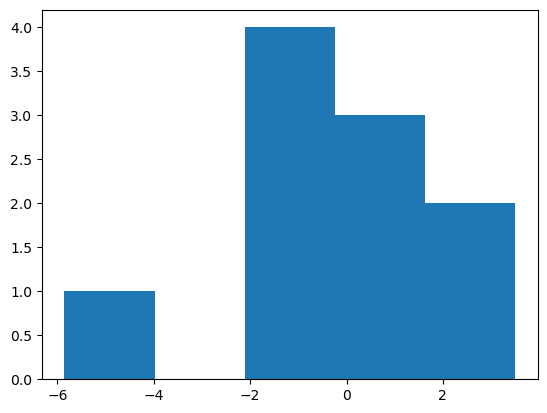

In [5]:
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)
plt.hist(xi, bins='fd')
plt.show()

Now let's use Bayes' theorem to find the posterior:

$$p(\mu,\gamma \mid {x_i}) \propto p({x_i} \mid \mu, \gamma) \, p(\mu, \gamma) = p({x_i} \mid \mu, \gamma) \, p(\mu) \, p(\gamma) \\
= \left[\prod_i \frac{1}{\pi \gamma} \left( \frac{\gamma^2}{\gamma^2 + (x_i-\mu)^2} \right) \right]\times 1 \times \frac{1}{\gamma} \\
= \left[\prod_i \frac{1}{\pi} \left( \frac{\gamma}{\gamma^2 + (x_i-\mu)^2} \right) \right]\times  \frac{1}{\gamma}$$

This can still be solved using the brute force computation on a grid, resulting in:

<img src="figures/Lcauchy.jpg" alt="Drawing" style="width: 600px;"/>

(this is Figure 5.10 in the textbook).

`emcee` actually expects to receive a function returning the natural log of the posterior, so we let's find the natural log:

$$ \log p(\mu, \gamma \mid {x_i}) = \left[\sum_i \log \left(\frac{\gamma}{\gamma^2 + (x_i-\mu)^2}\right)\right] - \log \gamma + {\rm const} \\
= \left[\sum_i \log \gamma - \log \left(\gamma^2 + (x_i-\mu)^2\right)\right] - \log \gamma + {\rm const}$$

We only need to know the unnormalized posterior, which is equivalent to dropping a constant in the log posterior that doesn't depend on $\mu$ or $\gamma$. We'll define separate functions for the log likelihood and the log prior, which isn't required, but will make it easier to change the prior if we want to.

We also know that $\gamma$ has to be positive, so our prior (and thus our posterior) is zero when $\gamma$ is negative. `emcee` [wants us](https://emcee.readthedocs.io/en/stable/user/faq/) to return `-np.inf` in these cases.

In [6]:
def myLogPrior(mu, gamma):
    if gamma > 0:
        return -np.log(gamma)
    else:
        return -np.inf
    
def myLogLikelihood(mu, gamma, data):
    if gamma > 0: # avoid taking log(0)
        return np.sum(np.log(gamma) - np.log(gamma**2 + (data-mu)**2))
    else:
        return -np.inf

# emcee expects the first argument to be a vector of parameters
def myLogPosterior(parameters, data):
    mu, gamma = parameters # unpack the parameters
    return myLogPrior(mu, gamma) + myLogLikelihood(mu, gamma, data)

Now let's set up and run the `emcee` sampler:

In [7]:
# emcee combines multiple "walkers", each of which is its own MCMC chain. 
# the number of trace results will be nwalkers * nsteps
ndim = 2  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
Nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[xi])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points
# and merge all of the walkers into one chain
emcee_trace  = sampler.chain[:, Nburn:, :].reshape(-1, ndim)

print("done")

done


The return is the sample from the distributon (known as a "chain", in MCMC):

In [8]:
emcee_trace

array([[0.44451829, 1.12423926],
       [0.64029353, 1.16299692],
       [0.64029353, 1.16299692],
       ...,
       [0.55419371, 0.7931099 ],
       [0.68504805, 0.58385836],
       [0.66765879, 0.61166585]])

Let's visualize the full posterior by histogramming the sample, and compare it to the grid-based calculation:

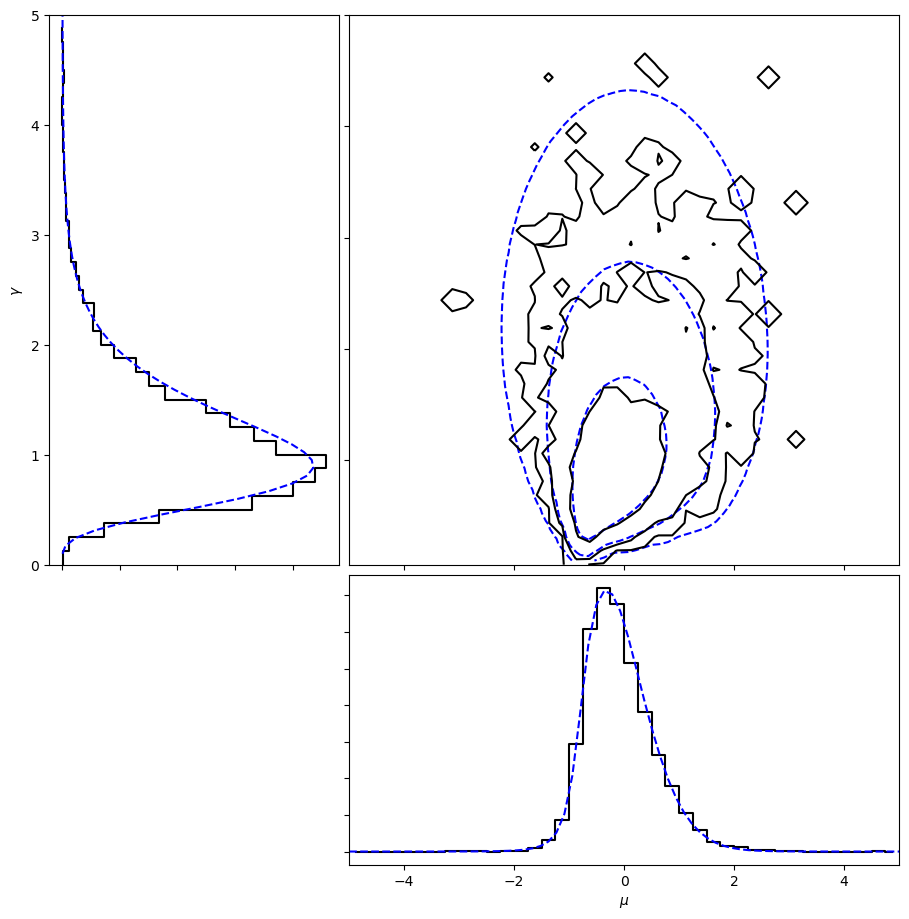

In [9]:
# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(emcee_trace[:,0],
                                             emcee_trace[:,1],
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

hist_mu, bins_mu = np.histogram(emcee_trace[:,0], bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(emcee_trace[:,1],
                                      bins=gamma_bins, density=True)

## this is code for the textbook figure 5.22, see
## http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html

def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))


# ----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(emcee_trace[:,0], bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(emcee_trace[:, 1],
                                      bins=gamma_bins, density=True)


# ----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 10))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

The contours denote 1,2, and 3-sigma credible regions, corresponding to $68.3\%$,  $95.5\%$ and $99.7\%$ probabilities.

I.e., we claim that our state of knowledge is such that we believe the true values of $\mu, \gamma$ are enclosed by the 3rd contour with $99.7\%$ confidence (and analogous for the inner-most and middle contour).

Note how the knowledge of the outer-most contour is "ratty" -- increasing the number of samples will increase its fidelity. Whether you have to do that depends on how important is it for you to know which values are very unlikely.

##  Markov Chain Monte Carlo with PyMC3

We will next use pyMC3 on the same problem.

Now let's sample the posterior with PyMC3.

Unlike `emcee`, which takes an arbitrary Python function proportional to the log of the posterior, PyMC3 requires us to construct the posterior by composing its [built-in distributions](https://docs.pymc.io/api/distributions/continuous.html).

We start by writing out the Bayes theorem:

$$
p(\mu, \gamma|D) \, d\mu \, d\gamma \propto p(D|\mu, \gamma) \cdot p(\mu, \gamma) \, d\mu \, d\gamma = Cauchy(D|\mu, \gamma) \cdot U(\mu) \cdot J(\gamma) \, d\mu \, d\gamma 
$$

where $U$ is the uniform distribution, and $J$ is the uninformative prior $1/\gamma$.

It's computationally more efficient to use $\log \gamma$ as a variable, so we do the change of variables:
$$ d\log \gamma = \frac{d\gamma}{\gamma} \\ \Rightarrow J(\gamma) d\gamma = \frac{d\gamma}{\gamma} = d\log \gamma$$
In the new variables, our posterior becomes:

$$
p(\mu, \log \gamma|D) \, d\mu \, d(\log \gamma) \propto Cauchy(D|\mu, e^{\log \gamma}) \cdot U(\mu) \cdot U(\log \gamma) \, d\mu \, d(\log \gamma)
$$

We can now go ahead and construct it with PyMC3 objects. 

Rather than explicitly multiplying the factors above, note how PyMC3 infers their relationships by via variable names:

In [10]:
## this is SIMPLIFIED code for the textbook figure 5.22, see
## http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html

# set up our model for mu and log_gamma
with pm.Model():
    mu = pm.Uniform('mu', -5, 5)                  # the two numbers are the right/left limits of the uniform dist.
    log_gamma = pm.Uniform('log_gamma', -10, 10)  # the two numbers are the right/left limits of the uniform dist.

    # set up our likelihood. by setting observed=xi, we tell PyMC3 this is our likelihood.
    x = pm.Cauchy('x', alpha=mu, beta=np.exp(log_gamma), observed=xi)

    # this will start the sampler
    trace = pm.sample(draws=12000, tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_gamma, mu]


Sampling 2 chains for 1_000 tune and 12_000 draw iterations (2_000 + 24_000 draws total) took 22 seconds.


PyMC3 used its default [No-U Turn Sampler (NUTS)](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf) sampler. It's very safe, but for some problems can be slow (we'll switch to Metropolis for that reason further below). (Check out Chi Feng's [animation of NUTS](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=NaiveNUTS&target=banana).)

Like with `emcee`, the output is a trace (a chain):

In [11]:
trace['mu']

array([-0.87178399,  0.27727193,  0.84774421, ..., -0.23460382,
       -0.45396154,  0.41643399])

In [12]:
trace['log_gamma']

array([ 0.29700436,  0.74314042,  0.20022947, ..., -0.30863559,
        0.15311075,  0.14886689])

In [13]:
trace['log_gamma'].shape

(24000,)

Let's plot it (two-dimensional posterior + marginal distributions):

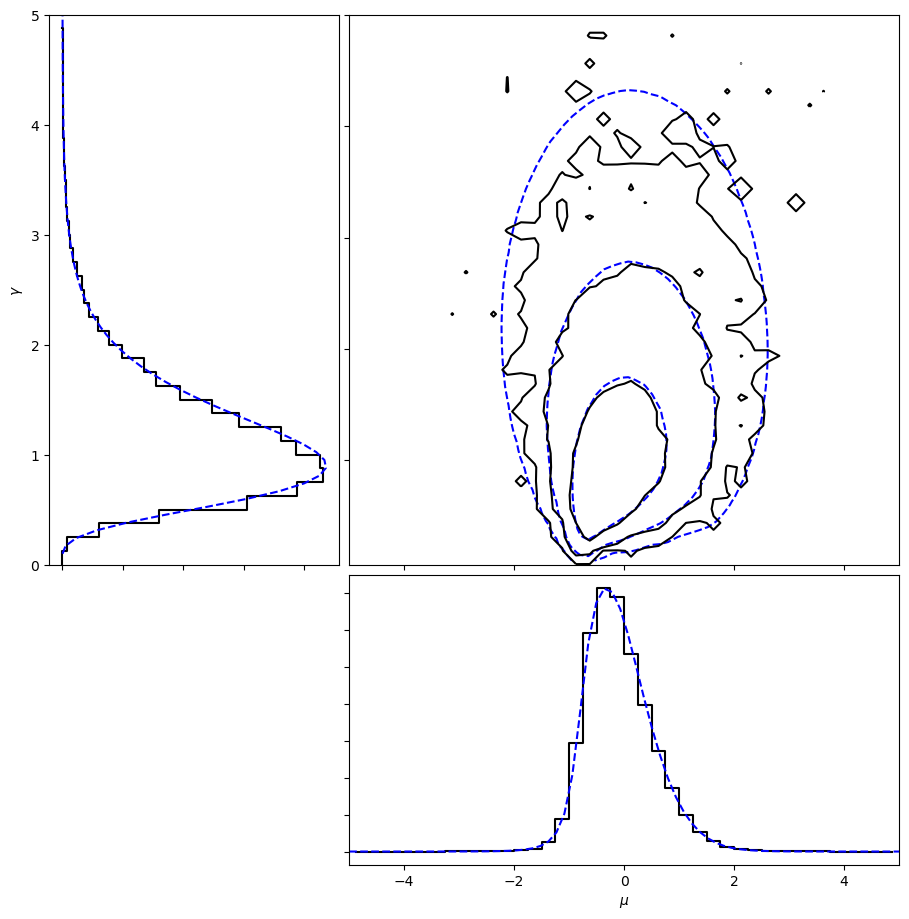

In [14]:
# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace['mu'],
                                             np.exp(trace['log_gamma']),
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

hist_mu, bins_mu = np.histogram(trace['mu'], bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(np.exp(trace['log_gamma']),
                                      bins=gamma_bins, density=True)
## this is code for the textbook figure 5.22, see
## http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html

def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))


# ----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace['mu'], bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(np.exp(trace['log_gamma']),
                                      bins=gamma_bins, density=True)


# ----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 10))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

## Modelling bursts

Imagine we observe an object that instantaneously brightens, then shows an exponential fall-off (e.g., a _very_ simplified supernova model):

$$ F(t) = b_0 + A \cdot e^{-\alpha (t - T)} $$

for $t > T$ and $F(t) = b_0$ before the burst. The parameters are the brightness before the burst $b_0$, amplitude of the burst, $A$, the time of the burst $T$, and the exponential fall-off constant $\alpha$.

We collect 100 observations with known photometric (Gaussian) errors. We wish to estimate the posterior of the parameters.

In [15]:
# A utility function to convert the traces (chains) to a Pandas DataFrame
def traces_to_pandas(traces, burnin):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var, :burnin] for var in varnames }
    return pd.DataFrame(cols)

Let's generate a mock the dataset:

In [16]:
# ----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    mask = (t >= T)
    y = b0 + mask * A * np.exp(-alpha * (t - T))
    return y

np.random.seed(10)

N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
sigma = 1.0

t = np.sort(100 * np.random.random(N))

y_true = burst(t, b0_true, A_true, alpha_true, T_true)
y_obs = np.random.normal(y_true, sigma)

Here's what it looks like:

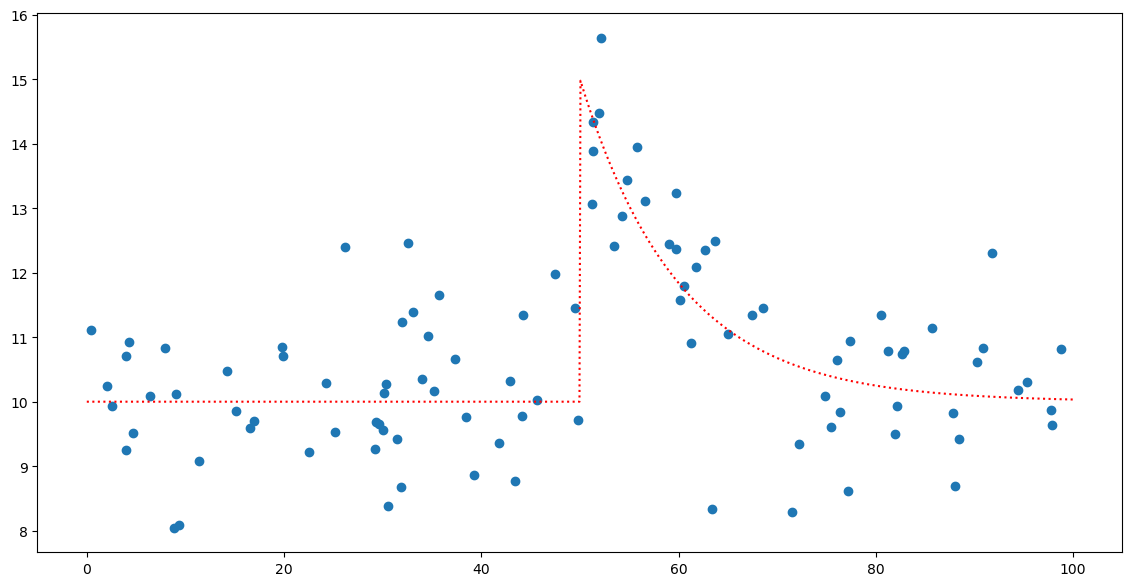

In [17]:
plt.figure(figsize=(14, 7))
plt.scatter(t, y_obs)

# uncomment to overplot the burst w/o observational errors.
tt = np.linspace(0, 100, 1000)
plt.gca().plot(tt, burst(tt, b0_true, A_true, alpha_true, T_true), c='red', linestyle=':');

Set up and sample a PyMC3 model:

In [18]:
with pm.Model():
    b0 = pm.Uniform('b0', 0, 50)
    A = pm.Uniform('A', 0, 50)
    T = pm.Uniform('T', 0, 100)
    log_alpha = pm.Uniform('log_alpha', -10, 10)

    y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T), sd=sigma, observed=y_obs)

    step = pm.Metropolis()
    traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [log_alpha]
>Metropolis: [T]
>Metropolis: [A]
>Metropolis: [b0]


Sampling 1 chain for 1_000 tune and 25_000 draw iterations (1_000 + 25_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Let's plot the results

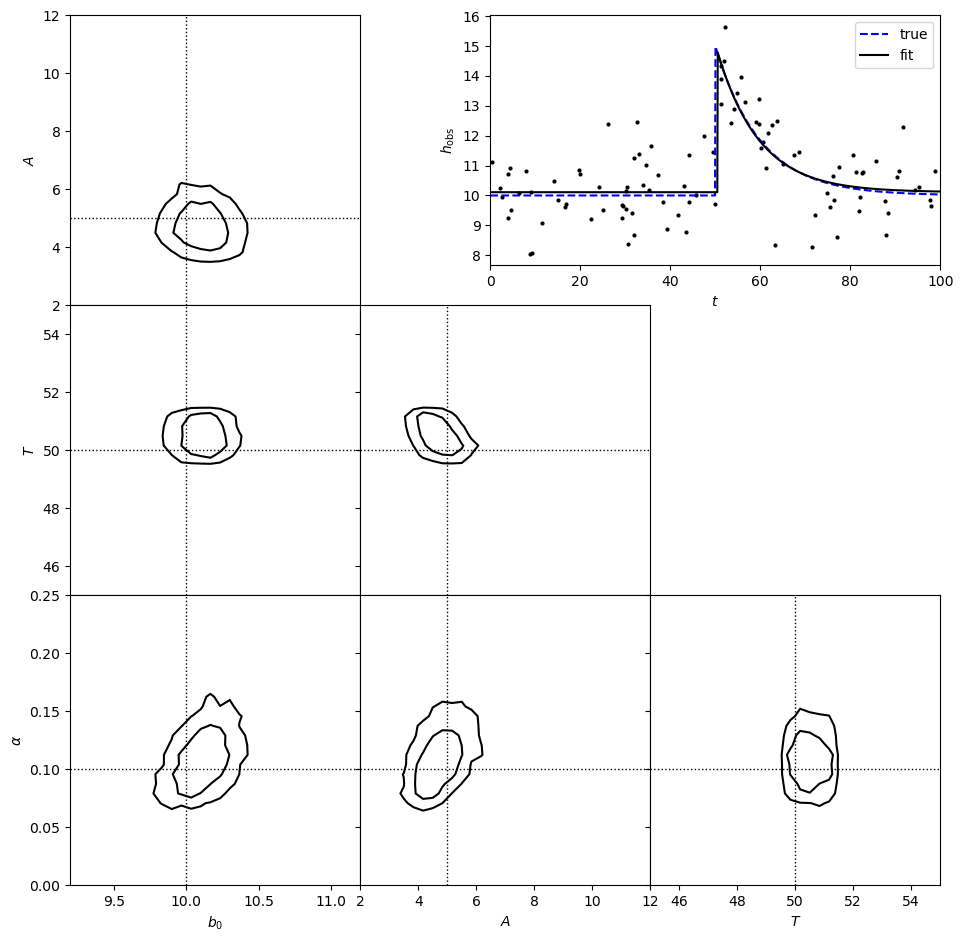

In [19]:
df = traces_to_pandas(traces, 1000)
df["alpha"] = np.exp(traces['log_alpha'])
del df["log_alpha"]

variables = ['b0', 'A', 'T', 'alpha']
labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1000)
y_fit = burst(t_fit, **df.median())
y_true = burst(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_true, '--', c='blue', label="true")
ax.plot(t_fit, y_fit, '-k', label="fit")
ax.legend()
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

Some things to notice:
  * The fit appears reasonable. There's no indication there were issues with sampling.
  * The contours enclose $68\%$ and $95.5\%$ probabilities
  * Much of what's in the plot has a physical interpretation:
    * Note how $T$ is tightly constrained  between $\sim 49.9$ and $\sim 51.2$, but poorly constrained inside of that interval? That is because the two data points bracketing the burst are at those timestamps -- they give a strong indication the burst couldn't have happened earlier or later, but constrain poorly when it happened inbetween.
    * Note how $T$ and $A$ are strongly correlated? $T$ is poorly constrained between the two timesamps as discussed above. But if $T$ happened earlier (e.g., closer to $t = 49.9$), it that means the burst amplitude had to be *higher*, to explain the observed amplitude at $t=51.2$. Similarly, if it occurred closer to $51.2$, the amplitude had to be lower. That's what the tilt of the contours tells us.
    * Similarly, note how $A$-$\alpha$ are correlated. If the burst started with a larger amplitude, it had to fall off faster to fit the datapoints at large $t$ well. Conversely, if it started with a lower amplitude, it musn't fall off very fast otherwise it will underestimate the values at large $t$.
    * Similar reasoning explains the correlation of $\alpha$ and $b_0$.
    * Finally, note the lack of correlation of $A$ and $b_0$. Increasing the amplitude doesn't have much of an effect on the estimate of $b_0$, as $b_0$ is primarily determined by data from before the burst happened.
    
**Studying correlations in posterior plots can bring insight into the physics, and develop our intuition about the relationships between model parameters.**

In [20]:
# find the observations bracketing the burst time, for the discussion above.
t[t <= T_true][-1], t[t > T_true][0]

(49.85070123025904, 51.21922633857766)